In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
rating1 = pd.read_csv('jester-data-1.csv', header=None)
rating2 = pd.read_csv('jester-data-2.csv', header=None)
rating3 = pd.read_csv('jester-data-3.csv', header=None)
rating = pd.concat([rating1, rating2, rating3])
rating.shape

(73421, 101)

In [3]:
d = rating.replace(99, np.nan)
d = d.as_matrix()[:, 1:]
d = np.round(d/10)
d = np.nan_to_num(d, 0)
d = d.astype(int)

In [6]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import regularizers
from keras import metrics
from keras import backend as K

In [109]:
batch_size = 50
original_dim = 100
latent_dim = 2
intermediate_dim = 16
epochs = 150
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_dim,),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [110]:
def vae_loss(x, x_decoded_mean):
    xent_loss = metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [111]:
np.random.shuffle(d)
training, test = d[:60000,:], d[60000:,:]

In [112]:
from keras.callbacks import TensorBoard
from datetime import datetime

In [113]:
datestr = str(datetime.now()).replace(':', '-').split('.')[0]

vae.fit(training, training,
        epochs=epochs,
        verbose=2,
        batch_size=batch_size,
        validation_data=(test, test),
        callbacks=[TensorBoard(log_dir='tmp\\vae-nodes' + str(intermediate_dim) + datestr)])

Train on 60000 samples, validate on 13421 samples
Epoch 1/150
2s - loss: 0.2753 - val_loss: 0.2343
Epoch 2/150
2s - loss: 0.2329 - val_loss: 0.2341
Epoch 3/150
3s - loss: 0.2328 - val_loss: 0.2342
Epoch 4/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 5/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 6/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 7/150
2s - loss: 0.2328 - val_loss: 0.2340
Epoch 8/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 9/150
2s - loss: 0.2327 - val_loss: 0.2341
Epoch 10/150
2s - loss: 0.2327 - val_loss: 0.2340
Epoch 11/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 12/150
2s - loss: 0.2328 - val_loss: 0.2340
Epoch 13/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 14/150
2s - loss: 0.2328 - val_loss: 0.2342
Epoch 15/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 16/150
2s - loss: 0.2328 - val_loss: 0.2341
Epoch 17/150
2s - loss: 0.2328 - val_loss: 0.2340
Epoch 18/150
2s - loss: 0.2327 - val_loss: 0.2340
Epoch 19/150
2s - loss: 0.2327 - val_loss: 0.2340
Epoch 20/

KeyboardInterrupt: 

In [ ]:
autoencoder.layers[1].get_weights()

In [114]:
# encode and decode some digits
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(test)
# decoded_imgs = decoder.predict(encoded_imgs
decoded_imgs = vae.predict(test)

In [115]:
import matplotlib.pyplot as plt

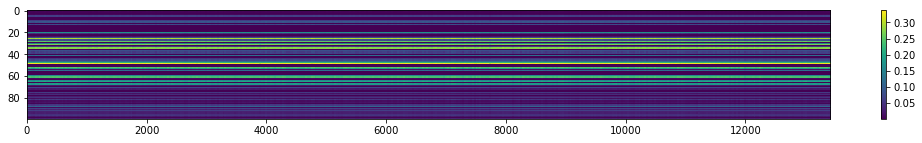

In [116]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(decoded_imgs.transpose(), aspect='auto')
plt.colorbar()

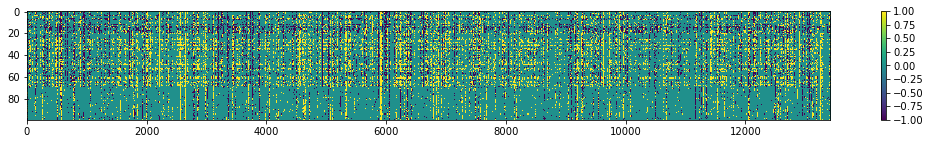

In [117]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(test.transpose(), aspect='auto')
plt.colorbar()

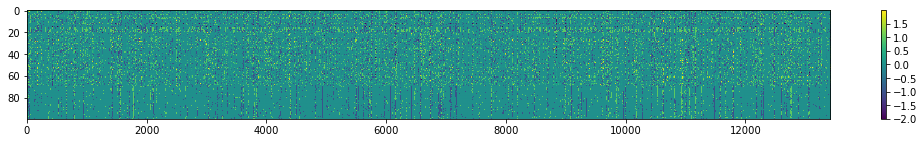

In [117]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow((decoded_imgs-test).transpose(), aspect='auto')
plt.colorbar()

In [118]:
decoded_imgs

array([[ -4.28942731e-04,   1.07292878e-03,   1.40913049e-04, ...,
          5.68258729e-05,  -6.08166238e-06,  -1.62403710e-04],
       [  1.60006093e-04,   1.59601425e-03,   8.06345837e-04, ...,
          8.03888543e-04,  -6.49531430e-04,  -1.33558072e-03],
       [  3.47441901e-03,   2.94838240e-03,   2.81591201e-03, ...,
          3.44787142e-03,  -4.29589953e-03,  -1.86499150e-03],
       ..., 
       [  3.67151111e-01,   3.48203033e-01,   3.00640941e-01, ...,
          1.79250631e-03,  -6.81934122e-04,  -2.74058431e-03],
       [  9.82096535e-05,   5.95973215e-05,   4.59065704e-05, ...,
          2.93623307e-05,  -1.42831850e-05,  -9.01475141e-05],
       [  4.00079973e-03,  -9.40028057e-02,   3.28637101e-03, ...,
          3.20197665e-04,   1.99253031e-04,  -1.02748524e-03]], dtype=float32)

In [123]:
liked = np.round(decoded_imgs)
test_liked = test

In [128]:
# Rough accuracy
sum(sum(liked == test_liked))/(liked.shape[0]*liked.shape[1])

0.80111243573504209

In [129]:
# Score error
sum(sum(abs(test_liked-liked))/(liked.shape[0]*liked.shape[1]))

0.20213173384993668

In [130]:
# Absolute error
sum(sum(abs(test-decoded_imgs))/(liked.shape[0]*liked.shape[1]))

0.21278710352508354

In [131]:
# Save the model
autoencoder.save('single-layer-n8-tanh-activation.h5')

In [97]:
autoencoder.predict(np.zeros((1, 100)))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [53]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [52]:
decoded_imgs.min()

-0.26814115

In [55]:
def custom_activation(x):
    return K.hard_sigmoid(x-2.5)